In [1]:
import medmnist

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [174]:
def train(model, loader, optimizer, convert_to_binary, epochs, device):
    criterion_ce = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        avg_loss = 0
        for inputs, targets in tqdm(loader):
            # forward + backward + optimize
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            targets = targets.squeeze().float()
            # TODO: Convert to binary classification
            if convert_to_binary:
                outputs = torch.sigmoid(outputs)
                outputs = (outputs > 0.5).float()

                # Convert to binary tensor (1 if sum > 0, 0 otherwise)
                targets_binary = targets.squeeze().sum(dim=1)
                targets_binary = (targets_binary > 0).float().view(-1, 1)

                # Concatenate with the original tensor to get the final result
                targets = torch.cat([targets_binary, 1 - targets_binary], dim=1)
                targets = targets.requires_grad_()
                # Display the result
            loss = criterion_ce(outputs, targets)
            avg_loss += loss.item()

            loss.backward()
            optimizer.step()
        avg_loss /= len(loader)
        print('Epoch: {}\tLoss: {:.4f}'.format(epoch+1, avg_loss))
    return model

In [184]:
def test(model, data_loader, device, convert_to_binary):
    model.eval()
    y_true = torch.tensor([], device=device)
    y_score = torch.tensor([], device=device)

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            targets = targets.squeeze().long()
            # TODO: Convert to binary classification
            if convert_to_binary:
                outputs = torch.sigmoid(outputs)
                outputs = (outputs > 0.5).float()

                # Convert to binary tensor (1 if sum > 0, 0 otherwise)
                targets_binary = targets.squeeze().sum(dim=1)
                targets_binary = (targets_binary > 0).float().view(-1, 1)

                # Concatenate with the original tensor to get the final result
                targets = torch.cat([targets_binary, 1 - targets_binary], dim=1)
                targets = targets.requires_grad_()

            outputs = outputs.softmax(dim=-1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_preds = torch.max(y_score, dim=1)[1]

        # TODO: Accuracy
        # Calculate accuracy
        correct = (y_preds == y_true[:, 1].long()).sum().item()
        total = y_true.size(0)
        acc = correct / total

        print('Accuracy: %.3f' % (acc))

# Chest

In [123]:
data_flag_chest = 'chestmnist'
download = True

lr = 0.001

info_chest = INFO[data_flag_chest]
task_chest = info_chest['task']
n_channels_chest = info_chest['n_channels']
#n_classes_chest = len(info_chest['label'])
n_classes_chest = 2
DataClass_chest = getattr(medmnist, info_chest['python_class'], "binary-class")

In [124]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the chest data
train_dataset_chest = DataClass_chest(split='train', transform=data_transform, download=download)
test_dataset_chest = DataClass_chest(split='test', transform=data_transform, download=download)

train_dataset_chest_full = DataClass_chest(split='train', transform=data_transform, download=download)
train_loader_chest_full = data.DataLoader(dataset=train_dataset_chest_full, batch_size=256, shuffle=True)

# Lets pretend we only have labels for 300 training examples
train_dataset_chest.imgs = train_dataset_chest.imgs[:300]
train_dataset_chest.labels = train_dataset_chest.labels[:300]

# encapsulate data into dataloader form
train_loader_chest = data.DataLoader(dataset=train_dataset_chest, batch_size=64, shuffle=True)
test_loader_chest = data.DataLoader(dataset=test_dataset_chest, batch_size=64, shuffle=False)

Using downloaded and verified file: /Users/carlottaholzle/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/carlottaholzle/.medmnist/chestmnist.npz
Using downloaded and verified file: /Users/carlottaholzle/.medmnist/chestmnist.npz


In [175]:
# define a simple CNN model

class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )

        self.fc = nn.Sequential(
            nn.Linear(128*4, num_classes)
        )
        
        self.extract_embeddings = False

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # Return embeddings from layer3 - I am not sure where to best place this 
        # if self.extract_embeddings:
        #     return x
        
        x = self.layer4(x)
            
        x = x.view(x.size(0), -1)

        if self.extract_embeddings: 
            return x 
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_chest = Net(in_channels=n_channels_chest, num_classes=2).to(device)

optimizer_chest = optim.SGD(model_chest.parameters(), lr=lr, momentum=0.9)

model_chest = train(model_chest, train_loader_chest, optimizer_chest, convert_to_binary=True, epochs=20, device=device)

100%|██████████| 5/5 [00:00<00:00, 68.52it/s]


Epoch: 1	Loss: 0.7030


100%|██████████| 5/5 [00:00<00:00, 42.91it/s]


Epoch: 2	Loss: 0.7171


100%|██████████| 5/5 [00:00<00:00, 70.58it/s]


Epoch: 3	Loss: 0.7136


100%|██████████| 5/5 [00:00<00:00, 77.21it/s]


Epoch: 4	Loss: 0.7156


100%|██████████| 5/5 [00:00<00:00, 76.00it/s]


Epoch: 5	Loss: 0.7117


100%|██████████| 5/5 [00:00<00:00, 72.02it/s]


Epoch: 6	Loss: 0.7170


100%|██████████| 5/5 [00:00<00:00, 67.49it/s]


Epoch: 7	Loss: 0.7077


100%|██████████| 5/5 [00:00<00:00, 68.38it/s]


Epoch: 8	Loss: 0.7176


100%|██████████| 5/5 [00:00<00:00, 71.55it/s]


Epoch: 9	Loss: 0.7079


100%|██████████| 5/5 [00:00<00:00, 79.15it/s]


Epoch: 10	Loss: 0.7190


100%|██████████| 5/5 [00:00<00:00, 73.93it/s]


Epoch: 11	Loss: 0.7208


100%|██████████| 5/5 [00:00<00:00, 78.07it/s]


Epoch: 12	Loss: 0.7245


100%|██████████| 5/5 [00:00<00:00, 73.93it/s]


Epoch: 13	Loss: 0.7054


100%|██████████| 5/5 [00:00<00:00, 65.71it/s]


Epoch: 14	Loss: 0.7178


100%|██████████| 5/5 [00:00<00:00, 61.51it/s]


Epoch: 15	Loss: 0.7109


100%|██████████| 5/5 [00:00<00:00, 59.01it/s]


Epoch: 16	Loss: 0.7194


100%|██████████| 5/5 [00:00<00:00, 60.44it/s]


Epoch: 17	Loss: 0.7197


100%|██████████| 5/5 [00:00<00:00, 64.63it/s]


Epoch: 18	Loss: 0.7272


100%|██████████| 5/5 [00:00<00:00, 78.20it/s]


Epoch: 19	Loss: 0.7194


100%|██████████| 5/5 [00:00<00:00, 78.32it/s]

Epoch: 20	Loss: 0.7223


In [180]:
# Assuming train_dataset_chest.labels is a numpy array
labels = train_dataset_chest.labels

# Convert numpy array to PyTorch tensor
labels_tensor = torch.from_numpy(labels).unsqueeze(1)  # Add an extra dimension

# Convert to binary tensor (1 if at least one 1 is present, 0 otherwise)
binary_labels = (labels_tensor.sum(dim=1) > 0).float()

# Calculate the positive rate
positive_rate = binary_labels.mean().item()

# Print the result
print("Positive Rate:", positive_rate)

Positive Rate: 0.05166666582226753


In [185]:
# evaluation
print('==> Evaluating ...')
print('train')
test(model_chest, train_loader_chest, device, convert_to_binary=True)
print('test')
test(model_chest, test_loader_chest, device, convert_to_binary=True)

==> Evaluating ...
train
Accuracy: 0.527
test
Accuracy: 0.496


## Latent Space

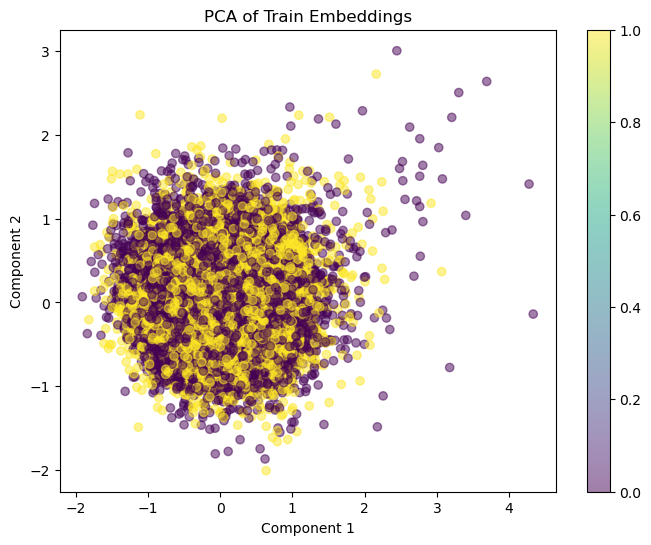

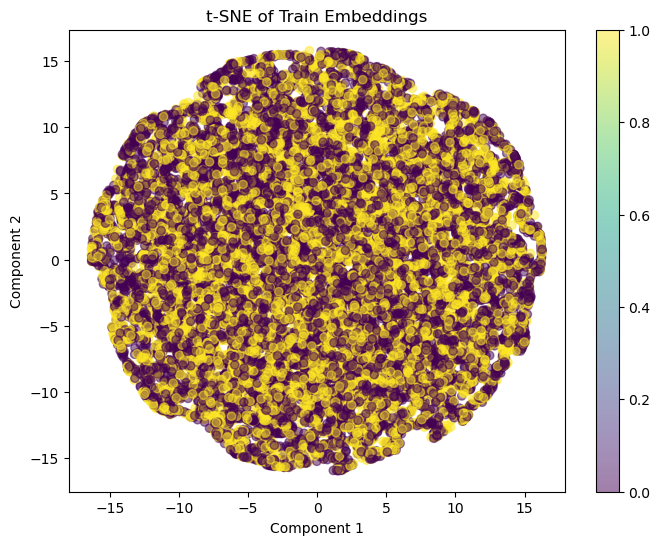

In [201]:
# EXAMINE LATENT SPACE

# Function to extract embeddings - TODO: Adjust the Net class to extract embeddings
def extract_embeddings(dataloader, model):
    embeddings = []
    labels = []

    with torch.no_grad():
        for x, target in dataloader:
            x = x.to(device)
            target = target.to(device)

            model.extract_embeddings = True
            output = model(x)
            model.extract_embeddings = False
            
            embeddings.append(output)
            labels.append(target)
    
    return torch.cat(embeddings), torch.cat(labels)

# Function to plot
def plot_embeddings(embeddings, labels, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

test_embeddings, test_labels = extract_embeddings(test_loader_chest, model_chest)

# TODO: convert labels to binary
test_labels_binary = test_labels.squeeze().sum(dim=1)
test_labels_binary = (test_labels_binary > 0).float().view(-1, 1)
test_labels = torch.cat([test_labels_binary, 1 - test_labels_binary], dim=1)
test_labels = test_labels[:, 0]

import numpy as np
import matplotlib.pyplot as plt

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# TODO: Apply PCA
def apply_pca(embeddings, num_components=2):
    pca = PCA(n_components=num_components)
    pca_result = pca.fit_transform(embeddings)
    return pca_result

pca_result = apply_pca(test_embeddings_flat)

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Apply t-SNE
def apply_tsne(embeddings, num_components=2, perplexity=30, n_iter=300):
    tsne = TSNE(n_components=num_components, perplexity=perplexity, n_iter=n_iter)
    tsne_result = tsne.fit_transform(embeddings)
    return tsne_result
tsne_result = apply_tsne(test_embeddings_flat)

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


## Autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# TODO: Define an autoencoder model that is compatable with the previous model. Use dropout with probability p
class Autoencoder(nn.Module):
    def __init__(self, p):

# Initialize the model, criterion, and optimizer
model_ae = Autoencoder(p=0.05).to(device)
criterion_ae = nn.MSELoss()
optimizer_ae = optim.AdamW(model_ae.parameters(), lr=0.0001, weight_decay=0.01)

# Metrics
psnr_metric = PeakSignalNoiseRatio().to(device)
ssim_metric = StructuralSimilarityIndexMeasure().to(device)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model_ae.train()
    for x in train_loader_chest_full:
        inputs, _ = x
        inputs = inputs.to(device)

        # Forward pass
        outputs = model_ae(inputs)
        loss = criterion_ae(outputs, inputs)

        psnr_value = psnr_metric(outputs, inputs)
        ssim_value = ssim_metric(outputs, inputs)

        # Backward pass and optimization
        optimizer_ae.zero_grad()
        loss.backward()
        optimizer_ae.step()

    # Print the metrics for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, PSNR: {psnr_value.item():.4f}, SSIM: {ssim_value.item():.4f}')

    psnr_metric.reset()
    ssim_metric.reset()

# Test the autoencoder on the test set
model_ae.eval()
test_loss = 0.0
psnr_value_test = 0.0, 0.0
ssim_value_test = 0.0, 0.0
with torch.no_grad():
    for x in test_loader_chest:
        inputs, _ = x
        inputs = inputs.to(device)
        outputs = model_ae(inputs)

        loss = criterion_ae(outputs, inputs)
        psnr_value_test = psnr_metric(outputs, inputs)
        ssim_value_test = ssim_metric(outputs, inputs)

        test_loss += loss.item()

average_test_loss = test_loss / len(test_loader_chest.dataset)
average_psnr_test = psnr_metric.compute()
average_ssim_test = ssim_metric.compute()

print(f'Average Test Loss: {average_test_loss:.4f}, Average PSNR: {average_psnr_test:.4f}, Average SSIM: {average_ssim_test:.4f}')


In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# TODO: Function to plot input and output images
def plot_images(model, test_loader, device, num_images=5):

# Use the function to plot images
plot_images(model_ae, test_loader_chest, device)

### Transfer Learning

In [ ]:
# Create a new model with randomly initialized weights
model_transfer = Net(in_channels=n_channels_chest, num_classes=2).to(device)

# TODO: Transfer the weights into the new model

# train
optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=lr, momentum=0.9)

model_transfer = train(model_transfer, train_loader_chest, optimizer_transfer, convert_to_binary=True, epochs=20, device=device)

In [ ]:
print('==> Evaluating ...')
test(model_transfer, train_loader_chest, device, convert_to_binary=True)
test(model_transfer, test_loader_chest, device, convert_to_binary=True)

# Pneumonia

In [ ]:
data_flag_pneumonia = 'pneumoniamnist'
info_pneumonia = INFO[data_flag_pneumonia]
task_pneumonia = info_pneumonia['task']
n_channels_pneumonia = info_pneumonia['n_channels']
n_classes_pneumonia = len(info_pneumonia['label'])
DataClass_pneumonia = getattr(medmnist, info_pneumonia['python_class'])

# load the pneumonia data
train_dataset_pneumonia = DataClass_pneumonia(split='train', transform=data_transform, download=download)
test_dataset_pneumonia = DataClass_pneumonia(split='test', transform=data_transform, download=download)

pil_dataset_pneumonia = DataClass_pneumonia(split='train', download=download)

# encapsulate data into dataloader form
train_loader_pneumonia = data.DataLoader(dataset=train_dataset_pneumonia, batch_size=64, shuffle=True)
test_loader_pneumonia = data.DataLoader(dataset=test_dataset_pneumonia, batch_size=64, shuffle=False)

In [ ]:
model_pneumonia = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

optimizer_pneumonia = optim.SGD(model_pneumonia.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train

model_pneumonia = train(model_pneumonia, train_loader_pneumonia, optimizer_pneumonia, convert_to_binary=False, epochs=10, device=device)

In [ ]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia, test_loader_pneumonia, device, convert_to_binary=False)

## Transfer learning

In [ ]:
# For transfer learning lets go back to the full dataset

model_chest_full = Net(in_channels=n_channels_chest, num_classes=2).to(device)
optimizer_chest_full = optim.SGD(model_chest_full.parameters(), lr=lr, momentum=0.9)

# train
model_chest_full = train(model_chest_full, train_loader_chest_full, optimizer_chest_full, convert_to_binary=True, epochs=20, device=device)

### Transfer learning - Frozen

In [ ]:
model_pneumonia_transfer_frozen = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights of the ENCODER from the chest model to the pneumonia model

# TODO: Freeze all layers except the FC

# Initialize the optimizer
optimizer_pneumonia_transfer_frozen = optim.SGD(model_pneumonia_transfer_frozen.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train
model_pneumonia_transfer_frozen = train(model_pneumonia_transfer_frozen, train_loader_pneumonia, optimizer_pneumonia_transfer_frozen, convert_to_binary=False, epochs=10, device=device)

In [ ]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_frozen, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_frozen, test_loader_pneumonia, device, convert_to_binary=False)

In [ ]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_frozen)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming train_embeddings and train_labels are obtained as shown in the previous step

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA

# TODO: Apply t-SNE

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


### Transfer learning - Trainable

In [ ]:
model_pneumonia_transfer_trainable = Net(in_channels=n_channels_pneumonia, num_classes=2).to(device)

# TODO: Transfer the weights from the chest model to the pneumonia model

# Initialize the optimizer
optimizer_pneumonia_transfer_trainable = optim.SGD(model_pneumonia_transfer_trainable.parameters(), lr=lr, momentum=0.9)

In [ ]:
# train
model_pneumonia_transfer_trainable = train(model_pneumonia_transfer_trainable, train_loader_pneumonia, optimizer_pneumonia_transfer_trainable, convert_to_binary=False, epochs=10, device=device)

In [ ]:
# evaluation

print('==> Evaluating ...')
print('train')
test(model_pneumonia_transfer_trainable, train_loader_pneumonia, device, convert_to_binary=False)
print('test')
test(model_pneumonia_transfer_trainable, test_loader_pneumonia, device, convert_to_binary=False)

In [ ]:
# TODO: EXAMINE LATENT SPACE
test_embeddings, test_labels = extract_embeddings(test_loader_pneumonia, model_pneumonia_transfer_trainable)

# Plot embeddings
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming train_embeddings and train_labels are obtained as shown in the previous step

# Flatten the embeddings
test_embeddings_flat = test_embeddings.view(test_embeddings.size(0), -1).cpu().numpy()

# TODO: Apply PCA

# TODO: Apply t-SNE

# Plot PCA result
plot_embeddings(pca_result, test_labels.cpu(), 'PCA of Train Embeddings')

# Plot t-SNE result
plot_embeddings(tsne_result, test_labels.cpu(), 't-SNE of Train Embeddings')


### BONUS: Transfer learning 